In [1]:
## Openslide

In [1]:
import os.path as osp
import openslide
from pathlib import Path

base_truth_dir = Path('mask(level4)')
slide_path = 'slide/16-S-042893_A1.mrxs'
truth_path = str(base_truth_dir/'Mask_16-S-042893_A1(positive class).png')
slide_png_path = 'image(level4)/Tumor_16-S-042893_A1(positive class).png'
slide_png = openslide.open_slide(slide_png_path)

slide = openslide.open_slide(slide_path)
truth = openslide.open_slide(truth_path)

print("original slide png dimensions %dx%d" % slide_png.dimensions)
print("original slide dimensions %dx%d" % slide.dimensions)
print("original truth dimensions %dx%d" % truth.dimensions)

original slide png dimensions 5316x10007
original slide dimensions 93970x234042
original truth dimensions 5316x10007


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
thumbnail = slide_png.get_thumbnail((slide_png.dimensions[0]/256, slide_png.dimensions[1]/256))
thumbnail_truth = truth.get_thumbnail((truth.dimensions[0]/256, truth.dimensions[1]/256))

# 3초

In [4]:
type(thumbnail) #PIL.Image.Image
thumbnail.size #(20, 39) # row col -> np.array (39,20)으로 바뀜

(20, 39)

In [5]:
# https://pillow.readthedocs.io/en/3.1.x/reference/Image.html
thumbnail_grey = np.array(thumbnail.convert('L'))  # L = R * 299/1000 + G * 587/1000 + B * 114/1000
# all non-zero values are set to 255 (white) 아하

In [6]:
#thumbnail_grey

In [7]:
from skimage.filters import threshold_otsu

In [8]:
thresh = threshold_otsu(thumbnail_grey)
# http://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.threshold_otsu

In [9]:
thresh # Upper threshold value. All pixels with an intensity higher than this value are assumed to be foreground.
#btw foreground and background : https://www.mathworks.com/matlabcentral/answers/280472-the-exact-difference-between-background-and-foreground

189

In [10]:
binary = thumbnail_grey > thresh

In [11]:
#binary

In [12]:
pd.DataFrame(binary).shape

(39, 20)

In [13]:
#k =pd.DataFrame(binary).stack()

In [14]:
#k[1]

In [15]:
patches =pd.DataFrame(pd.DataFrame(binary).stack())

In [16]:
len(patches)

780

In [17]:
patches.shape

(780, 1)

In [18]:
#patches

In [19]:
patches['is_tissue'] = ~patches[0] # 티슈인쪽만 true
patches.drop(0,axis=1,inplace=True)
#patches # 순서 바꿨네

In [20]:
patches['slide_path'] = slide_png_path

In [21]:
slide_contains_tumor = osp.basename(slide_png_path).startswith('Tumor_') # tumor만 가지고 있는 파일 이름으로 라벨

In [22]:
slide_contains_tumor

True

In [23]:
if slide_contains_tumor:
    #truth_slide_path = base_truth_dir/osp.basename(slide_png_path).replace
    truth_slide_path = str(base_truth_dir/'Mask_16-S-042893_A1(positive class).png')
    with openslide.open_slide(truth_slide_path) as truth:
        thumbnail_truth = truth.get_thumbnail((truth.dimensions[0]/256, truth.dimensions[1]/256))
    patches_y = pd.DataFrame(pd.DataFrame(np.array(thumbnail_truth.convert("L"))).stack())
    patches_y['is_tumor'] = patches_y[0]>0
    patches_y.drop(0,axis=1,inplace=True)
    
    samples = pd.concat([patches,patches_y],axis=1)
else:
    samples = patches
    samples['is_tumor'] = False

In [24]:
samples.head(5)

is_tissue                                         slide_path  is_tumor
0 0      False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False
  1      False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False
  2      False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False
  3      False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False
  4      False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False

In [25]:
filter_non_tissue=True

In [26]:
if filter_non_tissue:
        samples = samples[samples.is_tissue == True] # remove patches with no tissue

In [27]:
samples['tile_loc'] = list(samples.index)
samples.reset_index(inplace=True, drop= True)

In [28]:
#samples

In [29]:
#samples

In [30]:
print('Total patches in slide: %d' % len(samples))

Total patches in slide: 418


In [31]:
samples.is_tumor.value_counts()

False    225
True     193
Name: is_tumor, dtype: int64

In [32]:
samples.iloc[400:405]

is_tissue                                         slide_path  is_tumor  \
400       True  image(level4)/Tumor_16-S-042893_A1(positive cl...      True   
401       True  image(level4)/Tumor_16-S-042893_A1(positive cl...      True   
402       True  image(level4)/Tumor_16-S-042893_A1(positive cl...      True   
403       True  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
404       True  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   

     tile_loc  
400  (35, 14)  
401  (35, 15)  
402  (35, 16)  
403   (36, 6)  
404   (36, 7)

In [35]:
samples.shape

(418, 4)

In [85]:
list(range(0,400,30))

[0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390]

In [33]:

import cv2
from keras.utils.np_utils import to_categorical


Using TensorFlow backend.


In [38]:
BASE_TRUTH_DIR = Path('mask(level4)')

In [43]:
from openslide.deepzoom import DeepZoomGenerator 

In [44]:
# yield 공부!

def gen_imgs(samples, batch_size, base_truth_dir=BASE_TRUTH_DIR, shuffle=True):
    """This function returns a generator that 
    yields tuples of (
        X: tensor, float - [batch_size, 256, 256, 3]
        y: tensor, int32 - [batch_size, 256, 256, NUM_CLASSES]
    )
    
    
    input: samples: samples dataframe
    input: batch_size: The number of images to return for each pull
    output: yield (X_train, y_train): generator of X, y tensors
    
    option: base_truth_dir: path, directory of truth slides
    option: shuffle: bool, if True shuffle samples
    """
    
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        if shuffle:
            samples = samples.sample(frac=1) # shuffle samples col기준으로
        
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples.iloc[offset:offset+batch_size]
        
            images = []
            masks = []
            for _, batch_sample in batch_samples.iterrows():
                slide_contains_tumor = osp.basename(batch_sample.slide_path).startswith('Tumor_') # 이 부분도 Tumor를 구분하는 데이터
                #  path에 따라서 구분되어 있으면 open 열때 전체 패쓰 받고 contain 으로 해야하던가, 구분되는 경로의 패스 변수를 설정한다음 startswith
                
                with openslide.open_slide(batch_sample.slide_path) as slide:
                    tiles = DeepZoomGenerator(slide, tile_size=256, overlap=0, limit_bounds=False)
                    img = tiles.get_tile(tiles.level_count-1, batch_sample.tile_loc[::-1]) #이미지 순서가 (width,height)로 되어있으므로 
                    # batch-tile_loc은 (height, width임)
                    
                # only load truth mask for tumor slides
                if slide_contains_tumor:
                    truth_slide_path = str(base_truth_dir/'Mask_16-S-042893_A1(positive class).png')
                    #truth_slide_path = str(base_truth_dir / osp.basename(slide_path).replace('.tif', '_Mask.tif'))
                    with openslide.open_slide(truth_slide_path) as truth:
                        truth_tiles = DeepZoomGenerator(truth, tile_size=256, overlap=0, limit_bounds=False)
                        mask = truth_tiles.get_tile(truth_tiles.level_count-1, batch_sample.tile_loc[::-1])
                        mask = (cv2.cvtColor(np.array(mask), cv2.COLOR_RGB2GRAY) > 0).astype(int) # true면 흰색으로 마스크되어있네, 0이 검정
                else:
                    mask = np.zeros((256, 256))

                images.append(np.array(img))
                masks.append(mask)

            X_train = np.array(images)
            y_train = np.array(masks) #(batchsize ,256,256)
            y_train = to_categorical(y_train, num_classes=2).reshape(y_train.shape[0], 256, 256, 2)
            yield X_train, y_train

In [45]:
sample_gen = gen_imgs(samples.sample(32, random_state=42), 32, shuffle=False)

In [46]:
%time example_X, example_y  = next(sample_gen)

Wall time: 45.4 s


In [47]:
print('x.shape : ',example_X.shape)
print('y.shape : ',example_y.shape)

x.shape :  (32, 256, 256, 3)
y.shape :  (32, 256, 256, 2)


# Network

In [49]:
from keras.models import Sequential
from keras.layers import Lambda, Dropout
from keras.layers.convolutional import Convolution2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D

model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(256, 256, 3)))
model.add(Convolution2D(100, (5, 5), strides=(2, 2), activation='elu', padding='same'))
model.add(MaxPooling2D())
model.add(Convolution2D(200, (5, 5), strides=(2, 2), activation='elu', padding='same'))
model.add(MaxPooling2D())
model.add(Convolution2D(300, (3, 3), activation='elu', padding='same'))
model.add(Convolution2D(300, (3, 3), activation='elu',  padding='same'))
model.add(Dropout(0.1))
model.add(Convolution2D(2, (1, 1))) # this is called upscore layer for some reason?
model.add(Conv2DTranspose(2, (31, 31), strides=(16, 16), activation='softmax', padding='same'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [50]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 100)     7600      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 100)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 200)       500200    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 200)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 300)       540300    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 300)       810300    
__________

# Train

In [51]:
len(samples)

418

In [52]:
BATCH_SIZE = 32
N_EPOCHS = 10

NUM_SAMPLES = len(samples)

In [ ]:
# samples = find_patches_from_slide(slide_path)
# samples = samples.sample(NUM_SAMPLES, random_state=42)
# samples.reset_index(drop=True, inplace=True) 위에 함수 만들면

In [54]:
samples = samples.sample(NUM_SAMPLES,random_state=42)

In [56]:
len(samples)

418

In [58]:
samples.is_tumor.value_counts()

False    225
True     193
Name: is_tumor, dtype: int64

In [57]:
samples.head(3)

is_tissue                                         slide_path  is_tumor  \
321       True  image(level4)/Tumor_16-S-042893_A1(positive cl...      True   
324       True  image(level4)/Tumor_16-S-042893_A1(positive cl...      True   
388       True  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   

     tile_loc  
321   (30, 7)  
324  (30, 10)  
388  (34, 14)

In [60]:
#!pip install sklearn

  Running setup.py bdist_wheel for sklearn: started
  Running setup.py bdist_wheel for sklearn: finished with status 'done'
  Stored in directory: C:\Users\p\AppData\Local\pip\Cache\wheels\76\03\bb\589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [61]:
from sklearn.model_selection import StratifiedShuffleSplit

# split samples into train and validation set
# use StratifiedShuffleSplit to ensure both sets have same proportions of tumor patches
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(samples, samples["is_tumor"]):
        train_samples = samples.loc[train_index]
        validation_samples = samples.loc[test_index]

In [66]:
print('train set size : ',len(train_samples))
print('test set size : ',len(validation_samples))

train set size :  334
test set size :  84


In [67]:
from datetime import datetime

## TODO Add checkpoint mechanism to save old model before generating new

train_generator = gen_imgs(train_samples, BATCH_SIZE)
validation_generator = gen_imgs(validation_samples, BATCH_SIZE)

# Train model
train_start_time = datetime.now()
model.fit_generator(train_generator, np.ceil(len(train_samples) / BATCH_SIZE),
    validation_data=validation_generator,
    validation_steps=np.ceil(len(validation_samples) / BATCH_SIZE),
    epochs=N_EPOCHS)

train_end_time = datetime.now()
print("Model training time: %.1f minutes" % ((train_end_time - train_start_time).seconds / 60,))

Epoch 1/10
11/11 [==============================] - 481s 44s/step - loss: 0.6532 - acc: 0.6014 - val_loss: 0.4358 - val_acc: 0.8065
Epoch 2/10
11/11 [==============================] - 457s 42s/step - loss: 0.3741 - acc: 0.8573 - val_loss: 0.2973 - val_acc: 0.8773
Epoch 3/10
11/11 [==============================] - 471s 43s/step - loss: 0.3267 - acc: 0.8840 - val_loss: 0.2888 - val_acc: 0.8938
Epoch 4/10
11/11 [==============================] - 459s 42s/step - loss: 0.2324 - acc: 0.9183 - val_loss: 0.1992 - val_acc: 0.9302
Epoch 5/10
11/11 [==============================] - 461s 42s/step - loss: 0.2193 - acc: 0.9241 - val_loss: 0.1668 - val_acc: 0.9439
Epoch 6/10
11/11 [==============================] - 461s 42s/step - loss: 0.1694 - acc: 0.9413 - val_loss: 0.1268 - val_acc: 0.9642
Epoch 7/10
11/11 [==============================] - 481s 44s/step - loss: 0.1457 - acc: 0.9519 - val_loss: 0.1295 - val_acc: 0.9627
Epoch 8/10
11/11 [==============================] - 481s 44s/step - loss: 0.

In [69]:
# Save model
model.save('model.h5')

# Evaluation

## predict single patches

In [71]:
def predict_from_model(patch, model):
    """Predict which pixels are tumor.
    
    input: patch: 256x256x3, rgb image
    input: model: keras model
    output: prediction: 256x256x1, per-pixel tumor probability
    """
    
    prediction = model.predict(patch.reshape(1, 256, 256, 3))
    prediction = prediction[:, :, :, 1].reshape(256, 256)
    return prediction

In [72]:
import matplotlib.gridspec as gridspec

def plot_blend(patch, prediction, ax, alpha=0.75):
    """alpha blend patch and prediction.
    https://matplotlib.org/examples/pylab_examples/layer_images.html
    
    input: patch: 256x256x3, rgb image
    input: prediction: 256x256x1, per-pixel tumor probability
    input: ax: maplotlib Axes object
    input: alpha: alpha blend
    """
    
    dx, dy = 0.05, 0.05
    x = np.arange(0, patch.shape[1] - 1, dx)
    y = np.arange(0, patch.shape[0] - 1, dy)
    xmin, xmax, ymin, ymax = np.amin(x), np.amax(x), np.amin(y), np.amax(y)
    extent = xmin, xmax, ymin, ymax

    # fig = plt.figure(frameon=False, figsize=(10, 5))
    Z1 = cv2.cvtColor(patch, code=cv2.COLOR_RGB2GRAY)
    Z2 = prediction

    im1 = ax.imshow(Z1, cmap='gray', extent=extent)
    im2 = ax.imshow(Z2, cmap='jet', alpha=alpha, vmin=0.0, vmax=1.0,
                     extent=extent)
    ax.axis('off');

def plot_patch_with_pred(patch, truth, prediction, title_str='', alpha=0.6):
    """
    input: patch: 256x256x3, rgb image
    input: truth: 256x256x2, onehot output classes (not_tumor, tumor)
    input: prediction: 256x256x1, per-pixel tumor probability
    """
    gs = gridspec.GridSpec(2, 4, width_ratios=[10, 10, 19, 1])
    ax0 = plt.subplot(gs[0, 0])
    ax1 = plt.subplot(gs[0, 1])
    ax2 = plt.subplot(gs[1, 0])
    ax3 = plt.subplot(gs[1, 1])
    ax4 = plt.subplot(gs[:, 2])
    axc = plt.subplot(gs[:, 3])

    ax0.imshow(patch);
    ax0.set_title('Original')
    
    ax1.imshow(truth.argmax(axis=2), cmap='gray', vmin=0, vmax=1);
    ax1.set_title('Truth mask (white=tumor, black=not_tumor)')
    
    p = ax2.imshow(prediction, cmap='jet', vmin=0, vmax=1);
    ax2.set_title('Prediction heatmap')

    ax3.imshow((prediction > 0.5).astype(np.int), cmap='gray', vmin=0, vmax=1);
    ax3.set_title('Prediction mask (white=tumor, black=not_tumor)')
    
    plot_blend(patch, prediction, ax4, alpha)
    ax4.set_title('Original+Prediction blend')
    
    fig = plt.gcf()
    fig.set_size_inches(20, 10)
    fig.suptitle(title_str)
    fig.colorbar(p, cax=axc, orientation="vertical")
    axc.set_title('Probability pixel is tumor')

# tumor patch

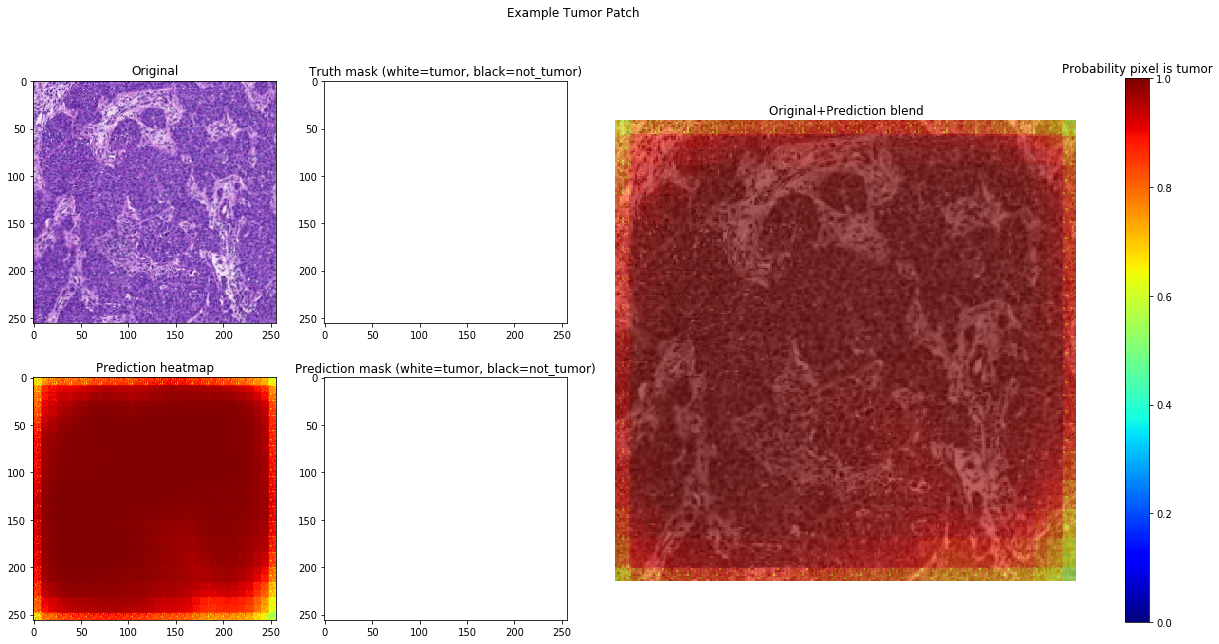

In [75]:
example_patch = example_X[1]
example_truth = example_y[1]

prediction = predict_from_model(example_patch, model)
plot_patch_with_pred(example_patch, example_truth, prediction, title_str='Example Tumor Patch')

count    65536.000000
mean         0.959809
std          0.062343
min          0.505718
25%          0.956927
50%          0.986407
75%          0.995521
max          0.999474
dtype: float64


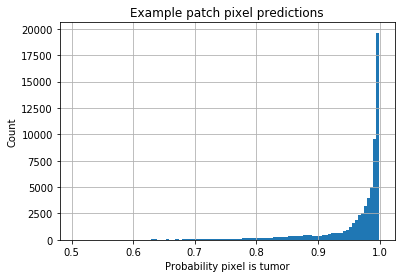

In [76]:
pred_s = pd.Series(prediction.flatten())
print(pred_s.describe())
ax = pred_s.hist(bins=100);
ax.set_title('Example patch pixel predictions');
ax.set_ylabel('Count');
ax.set_xlabel('Probability pixel is tumor');

## not tumor

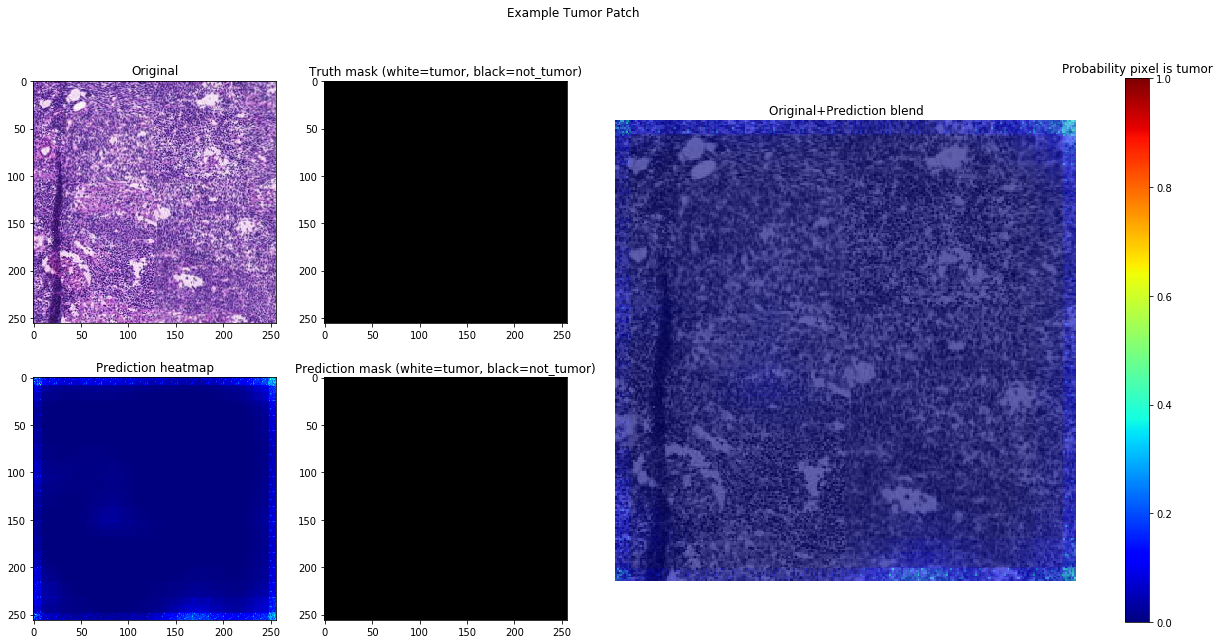

In [82]:
example_patch = example_X[2]
example_truth = example_y[2]

prediction = predict_from_model(example_patch, model)
plot_patch_with_pred(example_patch, example_truth, prediction, title_str='Example Tumor Patch')

count    65536.000000
mean         0.015437
std          0.033252
min          0.000002
25%          0.000770
50%          0.003062
75%          0.012234
max          0.452422
dtype: float64


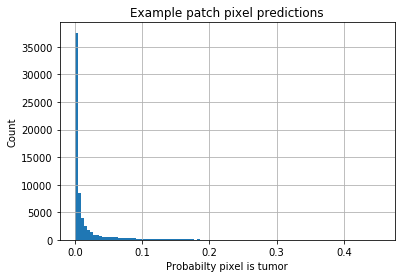

In [83]:
pred_s = pd.Series(prediction.flatten())
print(pred_s.describe())
ax = pred_s.hist(bins=100);
ax.set_title('Example patch pixel predictions');
ax.set_ylabel('Count');
ax.set_xlabel('Probabilty pixel is tumor');


## tough border patch

In [ ]:
example_patch = example_X[16]
example_truth = example_y[1]

prediction = predict_from_model(example_patch, model)
plot_patch_with_pred(example_patch, example_truth, prediction, title_str='Example Tumor Patch')

In [ ]:
pred_s = pd.Series(prediction.flatten())
print(pred_s.describe())
ax = pred_s.hist(bins=100);
ax.set_title('Example patch pixel predictions');
ax.set_ylabel('Count');
ax.set_xlabel('Probability pixel is tumor');

In [94]:
len(example_X)

32

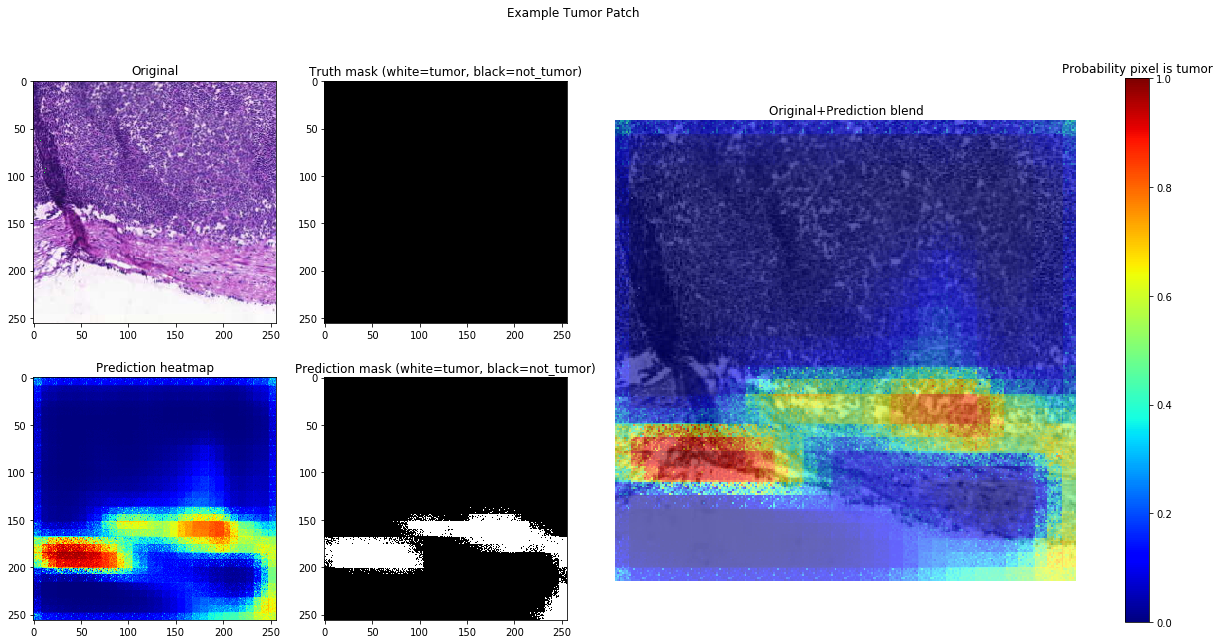

In [105]:
example_patch = example_X[9]
example_truth = example_y[9]

prediction = predict_from_model(example_patch, model)
plot_patch_with_pred(example_patch, example_truth, prediction, title_str='Example Tumor Patch')

## tough normal patch

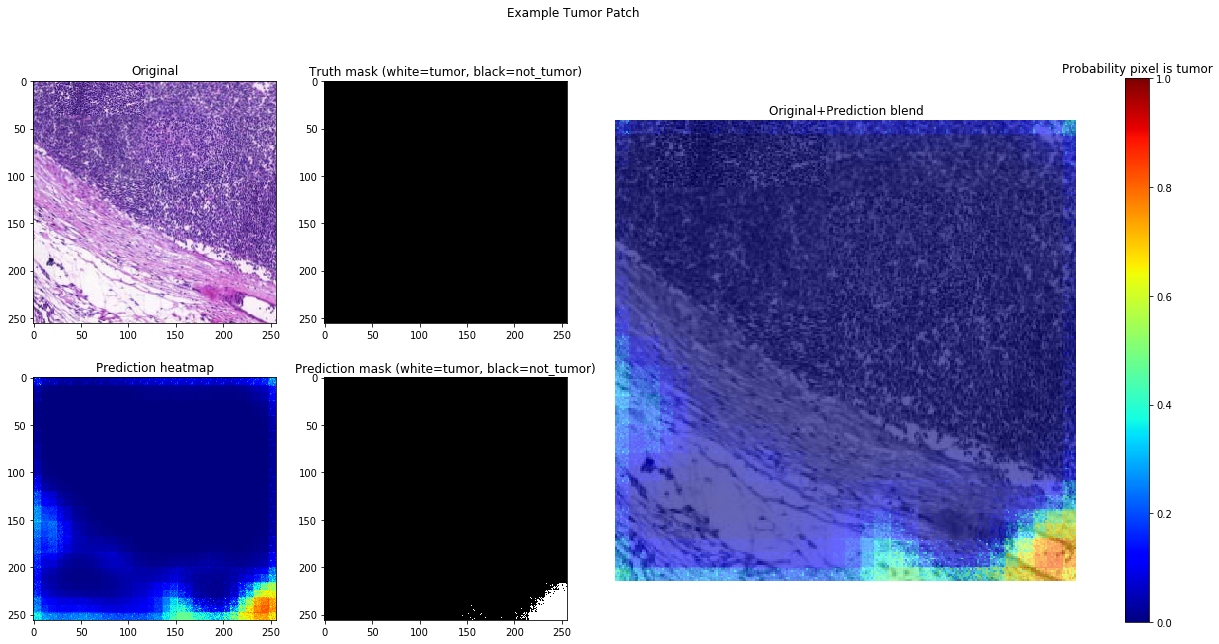

In [84]:
example_patch = example_X[16]
example_truth = example_y[16]

prediction = predict_from_model(example_patch, model)
plot_patch_with_pred(example_patch, example_truth, prediction, title_str='Example Tumor Patch')

count    6.553600e+04
mean     4.994343e-02
std      1.131400e-01
min      3.057196e-07
25%      1.412706e-04
50%      3.476760e-03
75%      4.252862e-02
max      8.454579e-01
dtype: float64


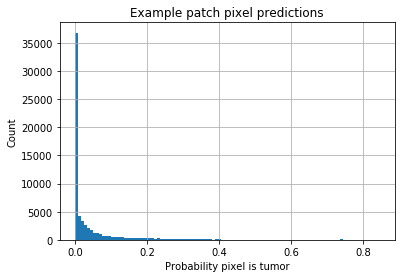

In [85]:

pred_s = pd.Series(prediction.flatten())
print(pred_s.describe())
ax = pred_s.hist(bins=100);
ax.set_title('Example patch pixel predictions');
ax.set_ylabel('Count');
ax.set_xlabel('Probability pixel is tumor');

#만약 이런걸 발견하면 annotation 문의할 수도

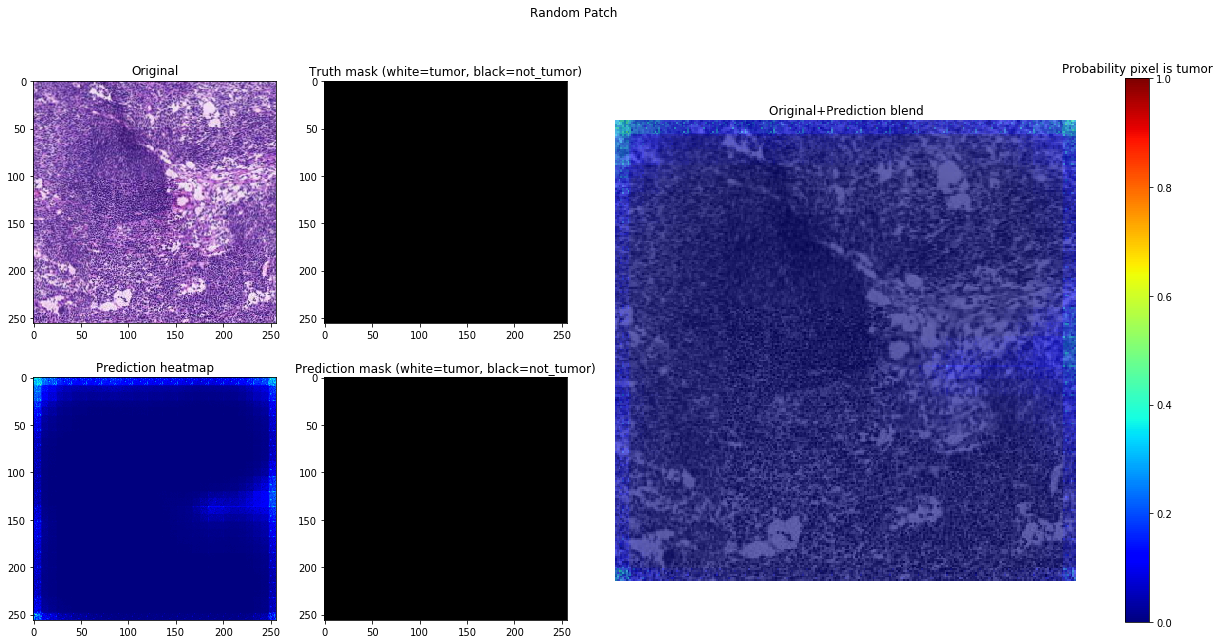

In [107]:
def get_random_patch_from_samples(samples, random_state=None):
    X_i, y_i = next(gen_imgs(samples.sample(1, random_state=random_state), 1))
    return X_i, y_i

X_i, y_i = get_random_patch_from_samples(samples)
pred_i = predict_from_model(X_i, model)
plot_patch_with_pred(X_i[0], y_i[0], pred_i, title_str='Random Patch')

# Calculate Performance Metrics

In [110]:
#! pip install tqdm

In [111]:
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

def predict_batch_from_model(patches, model):
    """Predict which pixels are tumor.
    
    input: patch: `batch_size`x256x256x3, rgb image
    input: model: keras model
    output: prediction: 256x256x1, per-pixel tumor probability
    """
    predictions = model.predict(patches)
    predictions = predictions[:, :, :, 1]
    return predictions

validation_generator = gen_imgs(validation_samples, BATCH_SIZE)
validation_steps = np.ceil(len(validation_samples) / BATCH_SIZE)

confusion_mtx = np.zeros((2, 2))

for i in tqdm(range(int(validation_steps))):
    X, y  = next(validation_generator)
    preds = predict_batch_from_model(X, model)
    
    y_true = y[:, :, :, 1].ravel()
    y_pred = np.uint8(preds > 0.5).ravel()
    
    confusion_mtx += confusion_matrix(y_true, y_pred, labels=[0, 1])

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:10<00:00, 44.50s/it]


In [112]:
tn = confusion_mtx[0, 0]
fp = confusion_mtx[0, 1]
fn = confusion_mtx[1, 0]
tp = confusion_mtx[1, 1]

In [113]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1_score = 2 * ((precision * recall) / (precision + recall))

print("Accuracy: %.2f" % accuracy)
print("Recall: %.2f" % recall)
print("Precision: %.2f" % precision)
print("F1 Score: %.2f" % f1_score)

Accuracy: 0.97
Recall: 0.96
Precision: 0.96
F1 Score: 0.96


# Predict whole slide

In [114]:
def find_patches_from_slide(slide_path, base_truth_dir=BASE_TRUTH_DIR, filter_non_tissue=True):
    """Returns a dataframe of all patches in slide
    input: slide_path: path to WSI file
    output: samples: dataframe with the following columns:
        slide_path: path of slide
        is_tissue: sample contains tissue
        is_tumor: truth status of sample
        tile_loc: coordinates of samples in slide
        
    
    option: base_truth_dir: directory of truth slides
    option: filter_non_tissue: Remove samples no tissue detected
    """
    base_truth_dir = Path(base_truth_dir)
    slide_contains_tumor = osp.basename(slide_path).startswith('Tumor_')
    
    with openslide.open_slide(slide_path) as slide:
        thumbnail = slide.get_thumbnail((slide.dimensions[0] / 256, slide.dimensions[1] / 256))
    
    thumbnail_grey = np.array(thumbnail.convert('L')) # convert to grayscale
    thresh = threshold_otsu(thumbnail_grey)
    binary = thumbnail_grey > thresh
    
    patches = pd.DataFrame(pd.DataFrame(binary).stack())
    patches['is_tissue'] = ~patches[0]
    patches.drop(0, axis=1, inplace=True)
    patches['slide_path'] = slide_path
    
    if slide_contains_tumor:
        #truth_slide_path = base_truth_dir / osp.basename(slide_path).replace('.tif', '_Mask.tif')
        truth_slide_path = str(base_truth_dir/'Mask_16-S-042893_A1(positive class).png')
        with openslide.open_slide(truth_slide_path) as truth:
            thumbnail_truth = truth.get_thumbnail((truth.dimensions[0] / 256, truth.dimensions[1] / 256)) 
        
        patches_y = pd.DataFrame(pd.DataFrame(np.array(thumbnail_truth.convert("L"))).stack())
        patches_y['is_tumor'] = patches_y[0] > 0
        patches_y.drop(0, axis=1, inplace=True)

        samples = pd.concat([patches, patches_y], axis=1)
    else:
        samples = patches
        samples['is_tumor'] = False
    
    if filter_non_tissue:
        samples = samples[samples.is_tissue == True] # remove patches with no tissue
    samples['tile_loc'] = list(samples.index)
    samples.reset_index(inplace=True, drop=True)
    return samples

In [115]:
all_samples = find_patches_from_slide(slide_png_path, filter_non_tissue=False)
print('Total patches in slide: %d' % len(all_samples))
all_samples.iloc[:5]
all_samples.is_tumor.value_counts()

Total patches in slide: 780


False    525
True     255
Name: is_tumor, dtype: int64

In [137]:
all_samples

is_tissue                                         slide_path  is_tumor  \
0        False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
1        False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
2        False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
3        False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
4        False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
5        False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
6        False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
7        False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
8        False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
9        False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
10       False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
11       False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
12       False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
13       False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
14       False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
15       False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
16       False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
17       False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
18       False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
19       False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
20       False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
21       False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
22       False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
23       False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
24       False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
25       False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
26       False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
27       False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
28        True  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
29        True  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
..         ...                                                ...       ...   
750       True  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
751       True  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
752       True  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
753      False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
754      False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
755      False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
756      False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
757      False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
758      False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
759      False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
760      False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
761      False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
762      False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
763      False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
764      False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
765      False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
766      False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
767      False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
768      False  image(level4)/Tumor_16-S-042893_A1(posi

In [120]:
n_cols

20

In [121]:
n_rows

39

In [126]:
n_samples

780

In [131]:
thumbnail = slide_png.get_thumbnail((n_cols, n_rows))

In [146]:
slide_png.dimensions

(5316, 10007)

In [145]:

thumbnail = np.array(thumbnail)
thumbnail.shape

(37, 20, 3)

In [149]:
slide_png.get_thumbnail((n_cols, n_rows))

In [154]:
list(range(0, n_samples, batch_size))

[0,
 32,
 64,
 96,
 128,
 160,
 192,
 224,
 256,
 288,
 320,
 352,
 384,
 416,
 448,
 480,
 512,
 544,
 576,
 608,
 640,
 672,
 704,
 736,
 768]

In [156]:
batch_samples

is_tissue                                         slide_path  is_tumor  \
0       False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
1       False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
2       False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
3       False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
4       False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
5       False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
6       False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
7       False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
8       False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
9       False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
10      False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
11      False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
12      False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
13      False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
14      False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
15      False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
16      False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
17      False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
18      False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
19      False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
20      False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
21      False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
22      False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
23      False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
24      False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
25      False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
26      False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
27      False  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
28       True  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
29       True  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
30       True  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   
31       True  image(level4)/Tumor_16-S-042893_A1(positive cl...     False   

   tile_loc  
0    (0, 0)  
1    (0, 1)  
2    (0, 2)  
3    (0, 3)  
4    (0, 4)  
5    (0, 5)  
6    (0, 6)  
7    (0, 7)  
8    (0, 8)  
9    (0, 9)  
10  (0, 10)  
11  (0, 11)  
12  (0, 12)  
13  (0, 13)  
14  (0, 14)  
15  (0, 15)  
16  (0, 16)  
17  (0, 17)  
18  (0, 18)  
19  (0, 19)  
20   (1, 0)  
21   (1, 1)  
22   (1, 2)  
23   (1, 3)  
24   (1, 4)  
25   (1, 5)  
26   (1, 6)  
27   (1, 7)  
28   (1, 8)  
29   (1, 9)  
30  (1, 10)  
31  (1, 11)

In [159]:
from matplotlib import cm
from tqdm import tqdm

output_dir = Path('')

alpha = 0.5

n_samples = len(all_samples)
n_cols = int(slide_png.dimensions[0] / 256)
n_rows = int(slide_png.dimensions[1] / 256)
assert n_cols * n_rows == n_samples

thumbnail = slide_png.get_thumbnail((n_cols, n_rows))
thumbnail = np.array(thumbnail)

# batch_size = n_cols
batch_size = 20
output_thumbnail_preds = list()

#i=0
for offset in tqdm(list(range(0, n_samples, batch_size))):
    batch_samples = all_samples.iloc[offset:offset+batch_size]
    png_fnames = batch_samples.tile_loc.apply(lambda coord: str(output_dir / ('%d_%d.png' % coord[::-1])))
    #print(batch_sample.size())
    X, _ = next(gen_imgs(batch_samples, batch_size, shuffle=False))
    
    if batch_samples.is_tissue.nunique() == 1 and batch_samples.iloc[0].is_tissue == False:
        # all patches in this row do not have tissue, skip them all
        output_thumbnail_preds.append(np.zeros(batch_size, dtype=np.float32))
        #print('all pathes in this row do not have tissue: ',coord[::-1])
        #i+=1
        # output pngs
        for i, png_fname in enumerate(png_fnames):
            plt.imsave(png_fname, X[i])
    else:
        # make predictions
        preds = predict_batch_from_model(X, model)
        output_thumbnail_preds.append(preds.mean(axis=(1,2)))
        #print('tissue: ',coord[::-1])
        #i+=1
        # overlay preds
        # save blended imgs
        for i, png_fname in enumerate(png_fnames):
            pred_i = preds[i]
            X_i = X[i]
            output_img = cv2.cvtColor(X_i, cv2.COLOR_RGB2GRAY)
            output_img2 = cv2.cvtColor(output_img.copy(), cv2.COLOR_GRAY2RGB)

            overlay = np.uint8(cm.jet(pred_i) * 255)[:,:,:3]
            blended = cv2.addWeighted(overlay, alpha, output_img2, 1-alpha, 0, output_img)
            
            plt.imsave(png_fname, blended)
        

output_thumbnail_preds = np.array(output_thumbnail_preds)




  0%|                                                                                           | 0/39 [00:00<?, ?it/s]


  3%|██▏                                                                                | 1/39 [00:27<17:22, 27.44s/it]


  5%|████▎                                                                              | 2/39 [00:55<17:05, 27.73s/it]


  8%|██████▍                                                                            | 3/39 [01:25<16:54, 28.18s/it]


 10%|████████▌                                                                          | 4/39 [01:53<16:32, 28.35s/it]


 13%|██████████▋                                                                        | 5/39 [02:21<16:01, 28.29s/it]


 15%|████████████▊                                                                      | 6/39 [02:49<15:26, 28.07s/it]


 18%|██████████████▉                                                                    | 7/39 [03:17<14:54, 27.96s/it]


 21%|████████████████

In [160]:
output_thumbnail_preds.shape

(39, 20)

In [172]:
thumbnail.shape

(37, 20, 3)

In [162]:
output_thumbnail_preds = output_thumbnail_preds.reshape(20, 39)
truth = openslide.open_slide(truth_path)

In [166]:
f, axes = plt.subplots(1, 2, figsize=(20, 39))
imshow(truth)

NameError: name 'imshow' is not defined

In [171]:
thumbnail[0]

array([[255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 254],
       [255, 255, 255],
       [255, 255, 253],
       [254, 253, 251],
       [251, 249, 248],
       [249, 246, 247],
       [254, 251, 250],
       [254, 255, 251],
       [255, 255, 255],
       [255, 255, 253],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255]], dtype=uint8)

In [170]:
output_thumbnail_preds.size

780

In [173]:
plot_blend(thumbnail, output_thumbnail_preds, ax=ax[0])

In [ ]:
plt.tight_layout();

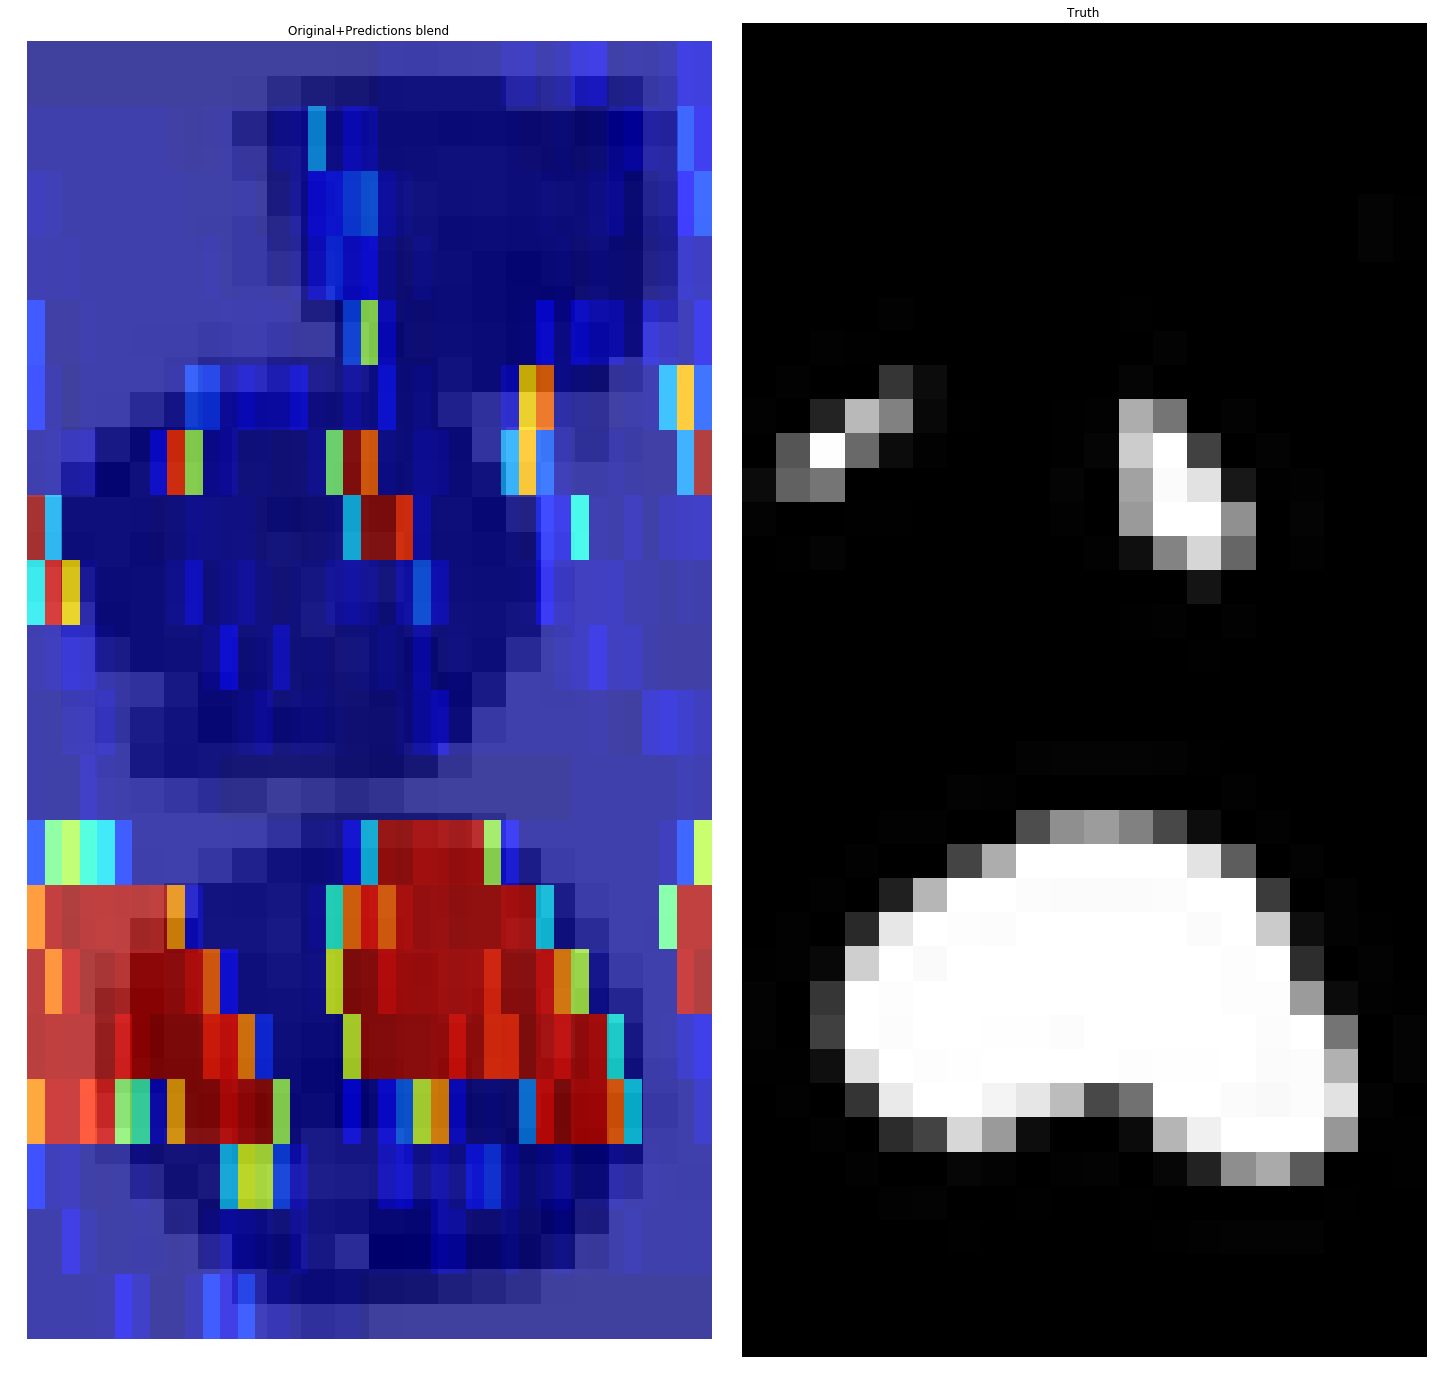

In [164]:
f, axes = plt.subplots(1, 2, figsize=(20, 39))
ax = axes.flatten()
plot_blend(thumbnail, output_thumbnail_preds, ax=ax[0])

thumbnail_truth = truth.get_thumbnail((truth.dimensions[0] / 256, truth.dimensions[1] / 256)) 
ax[1].imshow(thumbnail_truth.convert('L'), cmap='gray');
ax[0].set_title('Original+Predictions blend')
ax[1].set_title('Truth')
ax[1].axis('off');
plt.tight_layout();

# visualization

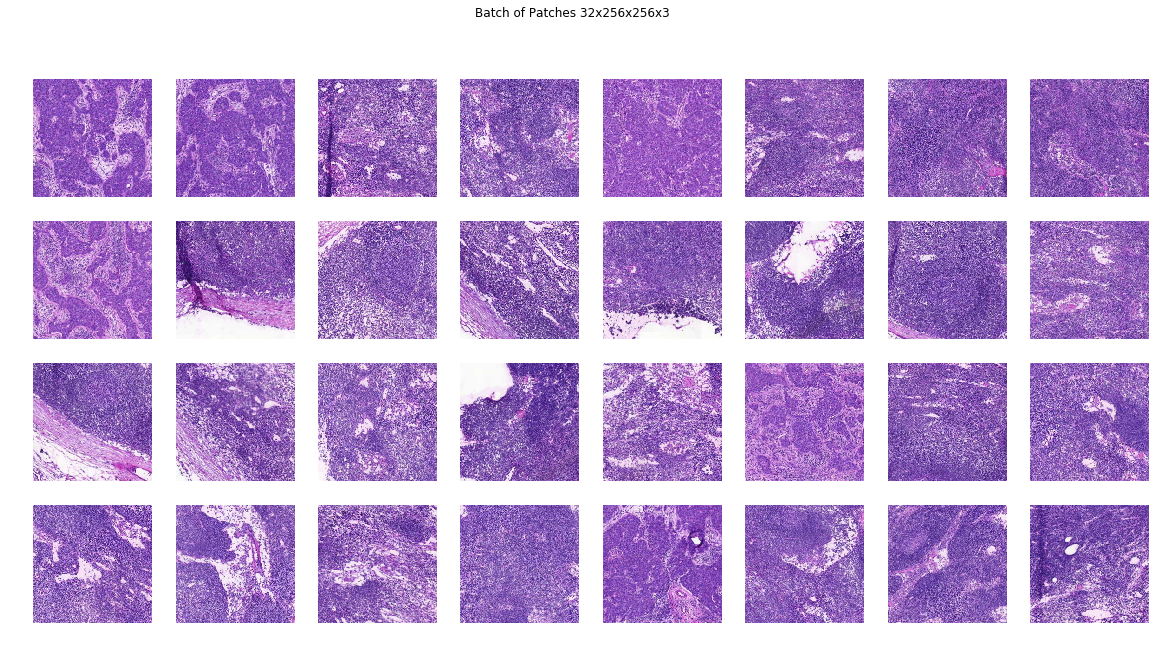

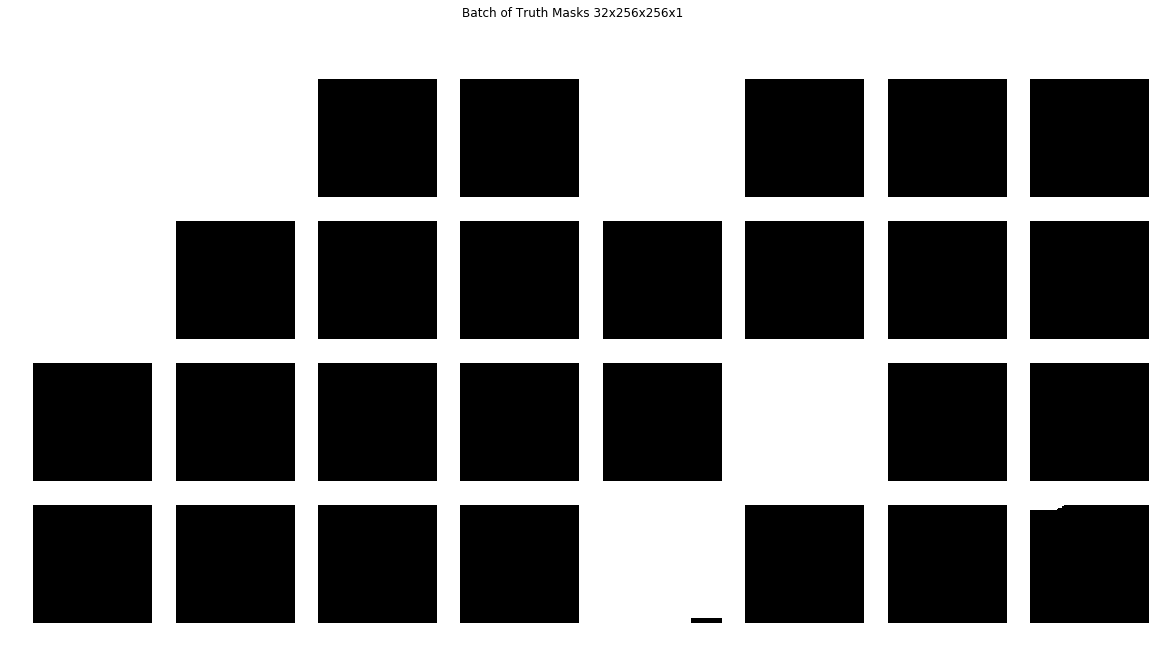

In [48]:
f, axes = plt.subplots(4, 8, figsize=(20, 10));
ax = axes.flatten()
for i in range(0, example_X.shape[0]):
    _ = ax[i].imshow(example_X[i]);
    _ = ax[i].axis('off');
f.suptitle('Batch of Patches 32x256x256x3');
    
f, axes = plt.subplots(4, 8, figsize=(20, 10));
ax = axes.flatten()    
for i in range(0, example_X.shape[0]):
    _ = ax[i].imshow(example_y[i].argmax(axis=2), cmap='gray', vmin=0, vmax=1);
    _ = ax[i].axis('off');
f.suptitle('Batch of Truth Masks 32x256x256x1');

In [ ]:
#I = numpy.asarray(PIL.Image.open('test.jpg'))
#im = PIL.Image.fromarray(numpy.uint8(I))

In [156]:
#K = I[I==0]

In [17]:
slide_png_path = 'image(level4)/16-S-042893_A1(positive class).png'
slide_png = openslide.open_slide(slide_png_path)
print("original slide png dimensions %dx%d" % slide_png.dimensions)

original slide png dimensions 5316x10007


In [79]:
slide.level_count # The number of levels in the slide. Levels are numbered from 0 (highest resolution) to level_count - 1 (lowest resolution).
slide.dimensions # (93970, 234042) # A (width, height) tuple for level 0 of the slide.
slide.level_dimensions #A list of (width, height) tuples, one for each level of the slide. level_dimensions[k] are the dimensions of level k.
'''((93970, 234042),
 (46985, 117021),
 (23492, 58510),
 (11746, 29255),
 (5873, 14627),
 (2936, 7313),
 (1468, 3656),
 (734, 1828),
 (367, 914),
 (183, 457))'''
slide.level_downsamples # (1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0, 512.0)
#slide.properties
slide.associated_images

<_AssociatedImageMap {'label': <PIL.Image.Image image mode=RGBA size=1770x1425 at 0x27C0304F208>, 'macro': <PIL.Image.Image image mode=RGBA size=1425x3544 at 0x27C0304F518>, 'thumbnail': <PIL.Image.Image image mode=RGBA size=734x1830 at 0x27C0304FE48>}>

In [72]:
slide_png.level_count

1

## Slide가 mrxs로 주어질때

아래 부분은 x_min_offset, y_min_offset 주어지면 따로 작업 해야할듯

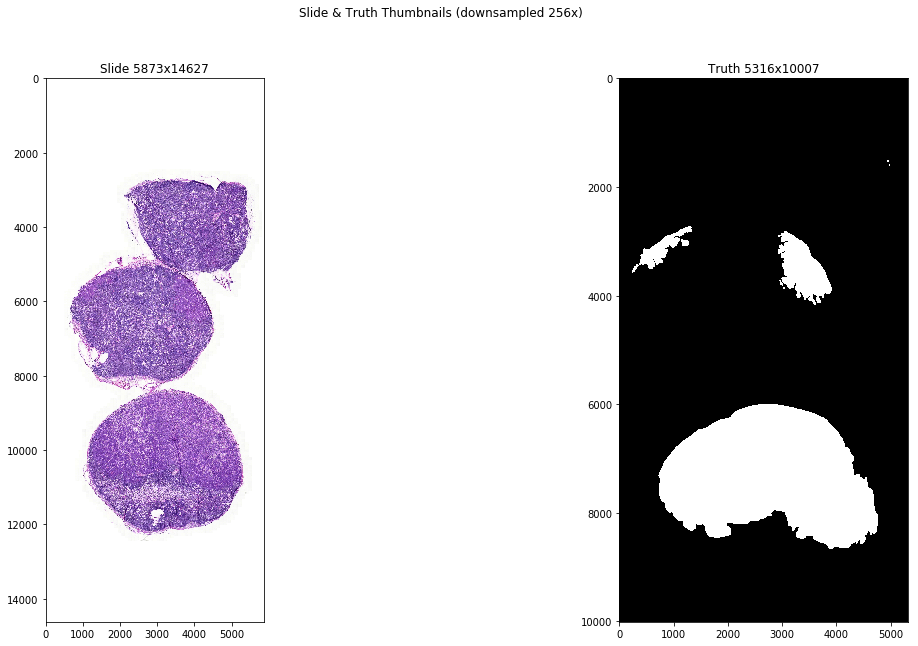

In [15]:
thumbnail = slide.get_thumbnail((slide.dimensions[0]/16, slide.dimensions[1]/16))
thumbnail_truth = truth.get_thumbnail((truth.dimensions[0], truth.dimensions[1]))

f, axes = plt.subplots(1, 2, figsize=(20, 10));
ax = axes.ravel()
ax[0].imshow(thumbnail);
ax[0].set_title('Slide %dx%d' % thumbnail.size)
ax[1].imshow(thumbnail_truth.convert('L'), cmap='gray');
ax[1].set_title('Truth %dx%d' % thumbnail_truth.size)
f.suptitle('Slide & Truth Thumbnails (downsampled 256x)');



## Slide가 mask와 비교할 수 있는 png로 주어질때



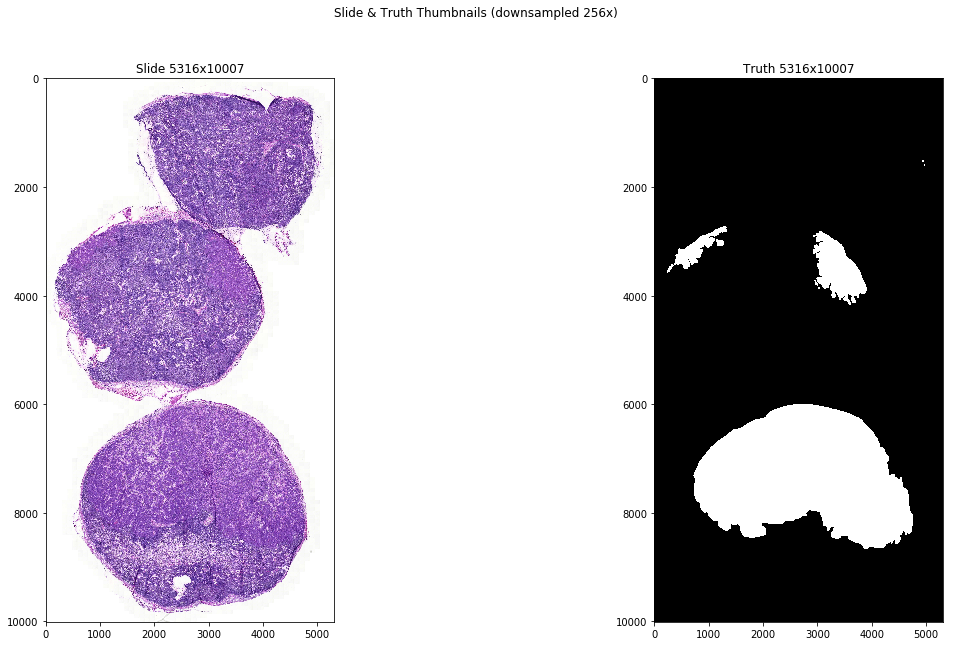

In [21]:
thumbnail2 = slide_png.get_thumbnail((slide_png.dimensions[0], slide_png.dimensions[1]))
thumbnail_truth = truth.get_thumbnail((truth.dimensions[0], truth.dimensions[1]))

f, axes = plt.subplots(1, 2, figsize=(20, 10));
ax = axes.ravel()
ax[0].imshow(thumbnail2);
ax[0].set_title('Slide %dx%d' % thumbnail2.size)
ax[1].imshow(thumbnail_truth.convert('L'), cmap='gray');
ax[1].set_title('Truth %dx%d' % thumbnail_truth.size)
f.suptitle('Slide & Truth Thumbnails (downsampled 256x)');

# Tissue area selection 

use Otsu's method to find areas on slide with tissue. Pixels with binary == False will be set of pathces avaliabe for training

In [23]:
from skimage.filters import threshold_otsu

img = np.array(thumbnail2.convert('L')) # convert to grayscale
thresh = threshold_otsu(img)
binary = img > thresh

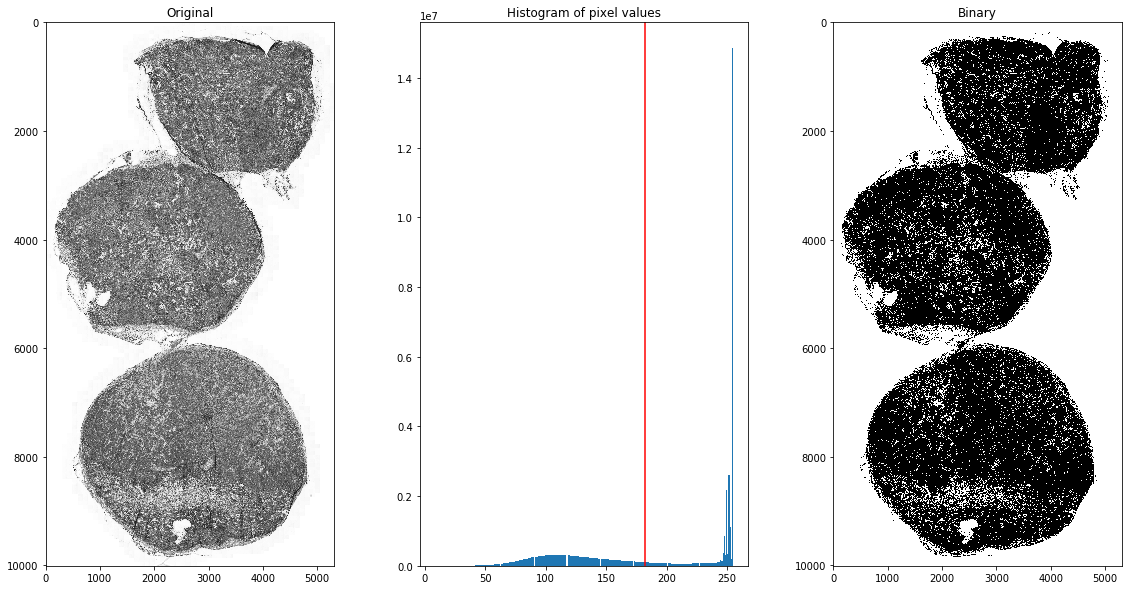

In [24]:
f, axes = plt.subplots(1, 3, figsize=(20, 10));
ax = axes.ravel();
ax[0].imshow(img, cmap='gray');
ax[0].set_title('Original');
ax[1].hist(img.ravel(), bins=256);
ax[1].set_title('Histogram of pixel values');
ax[1].axvline(thresh, color='r');
ax[2].imshow(binary, cmap='gray');
ax[2].set_title('Binary');

# Example Patches

DeepZoomGenerator(osr, tile_size=254, overlap=1, limit_bounds=False)¶

Parameters:	
- osr – the slide object
- tile_size (int) – the width and height of a single tile. For best viewer performance, tile_size + 2 * overlap should be a power of two.
- overlap (int) – the number of extra pixels to add to each interior edge of a tile
- limit_bounds (bool) – True to render only the non-empty slide region

variables:

- level_count
: The number of Deep Zoom levels in the image.

- tile_count
: The total number of Deep Zoom tiles in the image.

- level_tiles
: A list of (tiles_x, tiles_y) tuples for each Deep Zoom level. level_tiles[k] are the tile counts of level k.

- level_dimensions
: A list of (pixels_x, pixels_y) tuples for each Deep Zoom level. level_dimensions[k] are the dimensions of level k.

method:


### get_dzi(format)
- Return a string containing the XML metadata for the Deep Zoom .dzi file.
- Parameters:
        - format (str) : the delivery format of the individual tiles (png or jpeg)

### get_tile(level, address)

- Return an RGB Image for a tile.
- Parameters:	
        level (int) – the Deep Zoom level
        address (tuple) – the address of the tile within the level as a (column, row) tuple

### get_tile_coordinates(level, address)
- Return the OpenSlide.read_region() arguments corresponding to the specified tile. Most applications should use get_tile() instead.
- Parameters:	
        - level (int) – the Deep Zoom level
        - address (tuple) – the address of the tile within the level as a (column, row) tuple

### get_tile_dimensions(level, address)
- Return a (pixels_x, pixels_y) tuple for the specified tile.
- Parameters:	
        - level (int) – the Deep Zoom level
        - address (tuple) – the address of the tile within the level as a (column, row) tuple



In [26]:
from openslide.deepzoom import DeepZoomGenerator

tiles = DeepZoomGenerator(slide_png,tile_size=448, overlap=0, limit_bounds=False)
tiles_truth = DeepZoomGenerator(truth,tile_size=448, overlap=0, limit_bounds=False)
# deep zoom 2의 배수로 올라가서 최종 사이즈 안에 품을 수 있게 함.

In [83]:
tiles.level_count

15

In [86]:
tiles.tile_count

384

In [136]:
tiles.level_tiles # 15 (0~14)

((1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 2),
 (2, 3),
 (3, 6),
 (6, 12),
 (12, 23))

In [137]:
tiles.level_dimensions 

((1, 1),
 (1, 2),
 (2, 3),
 (3, 5),
 (6, 10),
 (11, 20),
 (21, 40),
 (42, 79),
 (84, 157),
 (167, 313),
 (333, 626),
 (665, 1251),
 (1329, 2502),
 (2658, 5004),
 (5316, 10007))

In [131]:
tiles.get_tile(11,(0,0)).size # 11 ~ 14 까지 (448,448)

(448, 448)

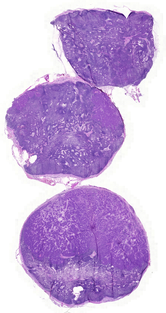

In [135]:
tiles.get_tile(9,(0,0))

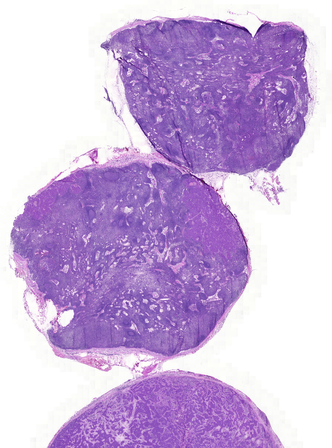

In [134]:
tiles.get_tile(10,(0,0))

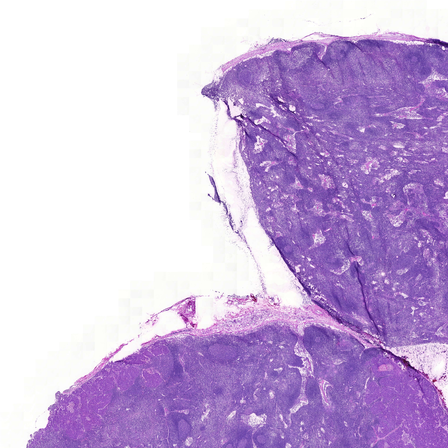

In [133]:
tiles.get_tile(11,(0,0))

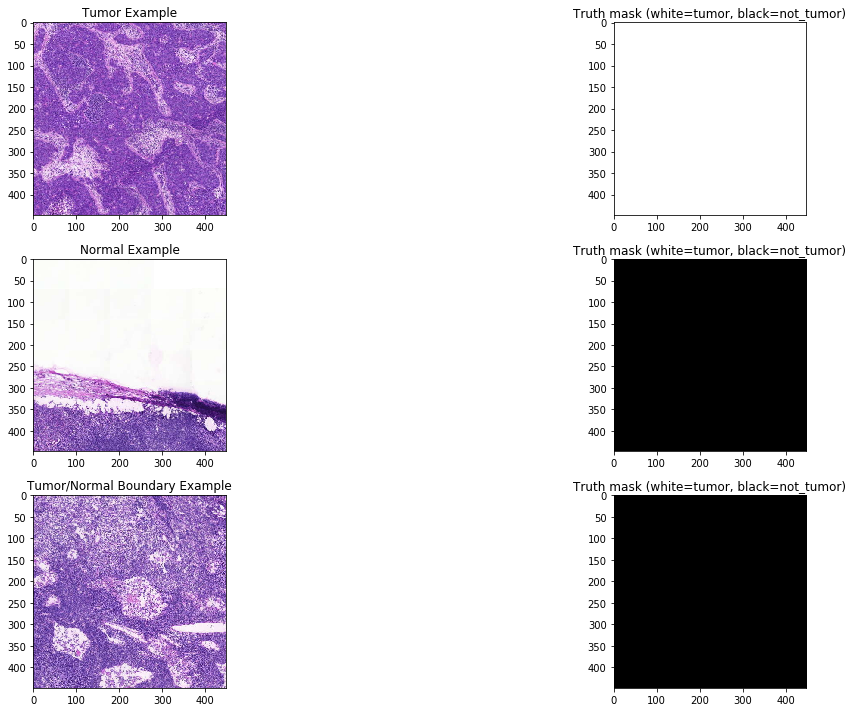

In [145]:
f, axes = plt.subplots(3, 2, figsize=(20, 10))
axes[0, 0].imshow(tiles.get_tile(tiles.level_count-1, (5, 16)))
axes[0, 0].set_title('Tumor Example');
axes[0, 1].imshow(tiles_truth.get_tile(tiles.level_count-1, (5, 16)));
axes[0, 1].set_title('Truth mask (white=tumor, black=not_tumor)')
axes[1, 0].imshow(tiles.get_tile(tiles.level_count-1, (7, 0)));
axes[1, 0].set_title('Normal Example');
axes[1, 1].imshow(tiles_truth.get_tile(tiles.level_count-1, (7, 0)));
axes[1, 1].set_title('Truth mask (white=tumor, black=not_tumor)')
axes[2, 0].imshow(tiles.get_tile(tiles.level_count-1, (5, 10)));
axes[2, 0].set_title('Tumor/Normal Boundary Example');
axes[2, 1].imshow(tiles_truth.get_tile(tiles.level_count-1, (5, 10)));
axes[2, 1].set_title('Truth mask (white=tumor, black=not_tumor)');
plt.tight_layout();

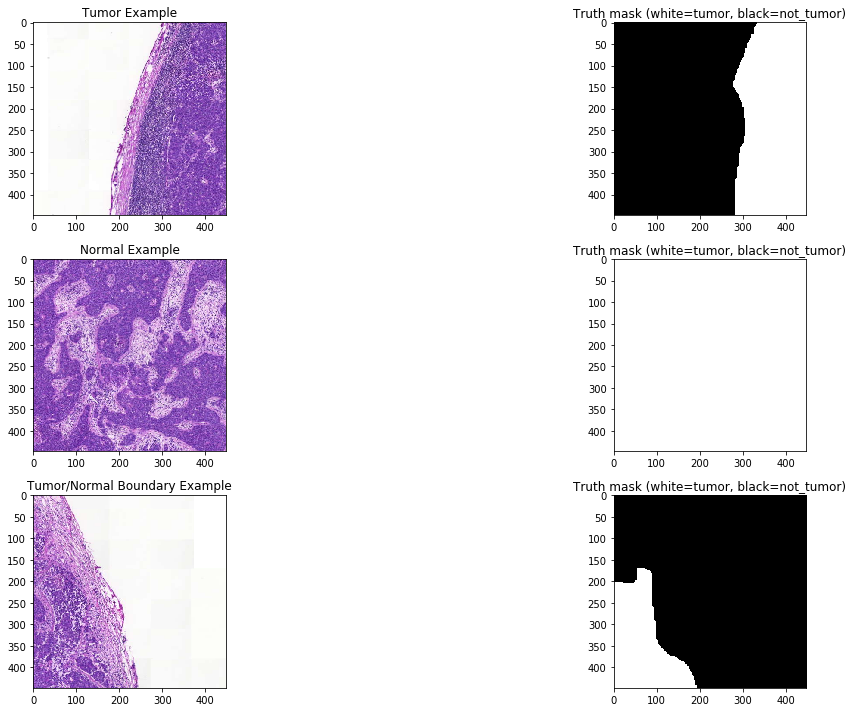

In [143]:

f, axes = plt.subplots(3, 2, figsize=(20, 10))
axes[0, 0].imshow(tiles.get_tile(tiles.level_count-1, (1, 16)))
axes[0, 0].set_title('Tumor Example');
axes[0, 1].imshow(tiles_truth.get_tile(tiles.level_count-1, (1, 16)));
axes[0, 1].set_title('Truth mask (white=tumor, black=not_tumor)')
axes[1, 0].imshow(tiles.get_tile(tiles.level_count-1, (3, 16)));
axes[1, 0].set_title('Normal Example');
axes[1, 1].imshow(tiles_truth.get_tile(tiles.level_count-1, (3, 16)));
axes[1, 1].set_title('Truth mask (white=tumor, black=not_tumor)')
axes[2, 0].imshow(tiles.get_tile(tiles.level_count-1, (10, 16)));
axes[2, 0].set_title('Tumor/Normal Boundary Example');
axes[2, 1].imshow(tiles_truth.get_tile(tiles.level_count-1, (10, 16)));
axes[2, 1].set_title('Truth mask (white=tumor, black=not_tumor)');
plt.tight_layout();

In [ ]:
# 본격적으로시작